In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [2]:
import sys

In [3]:
detectron_path = '/home/ubuntu/detectron/detectron'
sys.path.append(detectron_path)

In [4]:
import time
from collections import defaultdict

In [5]:
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
from caffe2.python import workspace

In [116]:
from core.config import cfg
from core.config import merge_cfg_from_file
from core.config import assert_and_infer_cfg

import core.test_engine as infer_engine
import datasets.dummy_datasets as dummy_datasets

import utils.c2 as c2_utils
import utils.vis as vis_utils
from utils.colormap import colormap
from utils.timer import Timer
import pycocotools.mask as mask_util

In [118]:
# Import after detectron imports of matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import numpy as np

## Caffe2 setup and loading of the model

In [8]:
c2_utils.import_detectron_ops()
# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)

In [9]:
workspace.GlobalInit(['caffe2', '--caffe2_log_level=0'])

In [10]:
!cat ../detectron/configs/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml

MODEL:
  TYPE: generalized_rcnn
  CONV_BODY: FPN.add_fpn_ResNet101_conv5_body
  NUM_CLASSES: 81
  FASTER_RCNN: True
  MASK_ON: True
NUM_GPUS: 8
SOLVER:
  WEIGHT_DECAY: 0.0001
  LR_POLICY: steps_with_decay
  BASE_LR: 0.02
  GAMMA: 0.1
  MAX_ITER: 180000
  STEPS: [0, 120000, 160000]
FPN:
  FPN_ON: True
  MULTILEVEL_ROIS: True
  MULTILEVEL_RPN: True
FAST_RCNN:
  ROI_BOX_HEAD: fast_rcnn_heads.add_roi_2mlp_head
  ROI_XFORM_METHOD: RoIAlign
  ROI_XFORM_RESOLUTION: 7
  ROI_XFORM_SAMPLING_RATIO: 2
MRCNN:
  ROI_MASK_HEAD: mask_rcnn_heads.mask_rcnn_fcn_head_v1up4convs
  RESOLUTION: 28  # (output mask resolution) default 14
  ROI_XFORM_METHOD: RoIAlign
  ROI_XFORM_RESOLUTION: 14  # default 7
  ROI_XFORM_SAMPLING_RATIO: 2  # default 0
  DILATION: 1  # default 2
  CONV_INIT: MSRAFill  # default GaussianFill
TRAIN:
  WEIGHTS: https://s3-us-west-2.amazonaws.com/detectron/ImageNetPretrained/MSRA/R-101.pkl
  DATASETS: ('coco_2014_train', 'coco_2014_valminusminival')
  SCALES: (800,)
  MAX_SIZE: 1333
  

In [15]:
!curl -o /tmp/detectron-download-cache/ImageNetPretrained/MSRA/R-101.pkl https://s3-us-west-2.amazonaws.com/detectron/ImageNetPretrained/MSRA/R-101.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170M  100  170M    0     0  7702k      0  0:00:22  0:00:22 --:--:-- 16.5M


In [10]:
!curl -O https://s3-us-west-2.amazonaws.com/detectron/35861858/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml.02_32_51.SgT4y1cO/output/train/coco_2014_train:coco_2014_valminusminival/generalized_rcnn/model_final.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  490M  100  490M    0     0  17.1M      0  0:00:28  0:00:28 --:--:-- 18.6M


In [11]:
merge_cfg_from_file('../detectron/configs/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml')

In [12]:
cfg.TEST.WEIGHTS = 'model_final.pkl'
cfg.NUM_GPUS = 1

In [13]:
assert_and_infer_cfg()

In [14]:
model = infer_engine.initialize_model_from_cfg()

## Inference of one img

In [15]:
im_name = "./demo/15673749081_767a7fa63a_k.jpg"

In [67]:
im = cv2.imread(im_name)
timers = defaultdict(Timer)

In [68]:
t = time.time()
with c2_utils.NamedCudaScope(0):
    cls_boxes, cls_segms, cls_keyps = infer_engine.im_detect_all(model, img, None, timers=timers)
print('Inference time: {:.3f}s'.format(time.time() - t))

Inference time: 0.740s


In [71]:
boxes, segms, keypoints, classes = vis_utils.convert_from_cls_format(cls_boxes, cls_segms, cls_keyps)

In [80]:
# Display in largest to smallest order to reduce occlusion
areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
sorted_inds = np.argsort(-areas)

Viz image with classes

In [ ]:
im = im[:, :, ::-1]  # # BGR -> RGB for visualization

In [137]:
dpi = 200
thresh = 0.7
box_alpha = 0.7
dataset = dummy_datasets.get_coco_dataset()
show_boxes = True
show_class = True
show_mask = True

In [138]:
def get_class_string(class_index, score, dataset):
    class_text = dataset.classes[class_index] if dataset is not None else \
        'id{:d}'.format(class_index)
    return class_text + ' {:0.2f}'.format(score).lstrip('0')

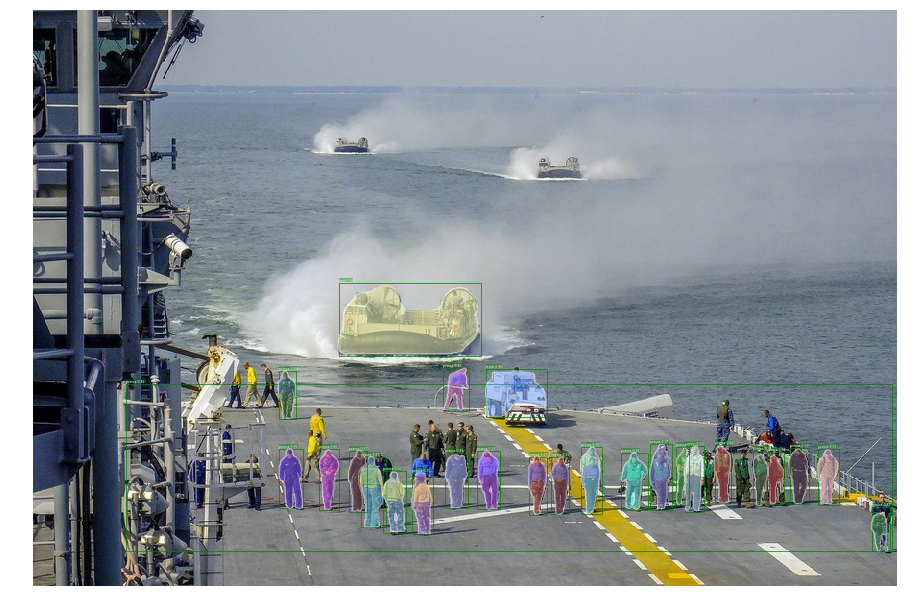

In [139]:
fig = plt.figure(frameon=False)
# fig.set_size_inches(im.shape[1] / dpi, im.shape[0] / dpi)
fig.set_size_inches(12, 12)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.axis('off')
fig.add_axes(ax)
ax.imshow(im)

if segms is not None:
    masks = mask_util.decode(segms)
color_list = colormap(rgb=True) / 255

for i in sorted_inds:
    bbox = boxes[i, :4]
    score = boxes[i, -1]
    if score < thresh:
        continue
    
    if show_boxes:
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1],
                          fill=False, edgecolor='green',
                          linewidth=1, alpha=box_alpha))
    
    if show_class:
            ax.text(
                bbox[0], bbox[1] - 2,
                get_class_string(classes[i], score, dataset),
                fontsize=3,
                family='serif',
                bbox=dict(
                    facecolor='g', alpha=0.4, pad=0, edgecolor='none'),
                color='white')
            
    if show_mask:

        if segms is not None and len(segms) > i:
            img = np.ones(im.shape)
            color_mask = color_list[mask_color_id % len(color_list), 0:3]
            mask_color_id += 1
            w_ratio = .4
            for c in range(3):
                color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
            for c in range(3):
                img[:, :, c] = color_mask[c]
            e = masks[:, :, i]

            _, contour, hier = cv2.findContours(
                e.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

            for c in contour:
                polygon = Polygon(
                    c.reshape((-1, 2)),
                    fill=True, facecolor=color_mask,
                    edgecolor='white', linewidth=1.2,
                    alpha=0.5)
                ax.add_patch(polygon)